In [ ]:
!unzip data.zip

In [1]:
# 기본 라이브러리
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings('ignore')

# Scikit-learn 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# PyTorch 및 Torchvision 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8-whitegrid')

In [3]:
# --- 경로 및 하이퍼파라미터 설정 ---

# 데이터 경로 (Colab 또는 로컬 환경에 맞게 수정)
# 예시: './fruits-360_dataset/fruits-360/'
DATA_PATH = '/content/fruits-360_dataset/fruits-360'
TRAIN_DIR = os.path.join(DATA_PATH, 'Training')
TEST_DIR = os.path.join(DATA_PATH, 'Test')


# PyTorch 학습을 위한 장치 설정 (GPU 우선 사용)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

# 하이퍼파라미터
BATCH_SIZE = 64
IMG_SIZE = 224
EPOCHS = 5 # 전이학습은 적은 에포크로도 충분한 성능을 보일 수 있습니다.
LEARNING_RATE = 0.001

Using device: cpu


In [4]:
# 데이터 경로를 DataFrame으로 변환하는 함수
def create_df(directory):
    paths = glob(os.path.join(directory, '*/*.jpg'))
    labels = [os.path.basename(os.path.dirname(p)) for p in paths]
    df = pd.DataFrame({'filepath': paths, 'label': labels})
    return df

# 학습 및 테스트 데이터프레임 생성
train_df = create_df(TRAIN_DIR)
test_df = create_df(TEST_DIR)

# 클래스 정보 추출
classes = sorted(train_df['label'].unique())
num_classes = len(classes)
class_to_idx = {name: i for i, name in enumerate(classes)}
idx_to_class = {i: name for i, name in enumerate(classes)}


print(f"총 학습 이미지 개수: {len(train_df)}")
print(f"총 테스트 이미지 개수: {len(test_df)}")
print(f"총 클래스 개수: {num_classes}")

총 학습 이미지 개수: 67692
총 테스트 이미지 개수: 22688
총 클래스 개수: 131


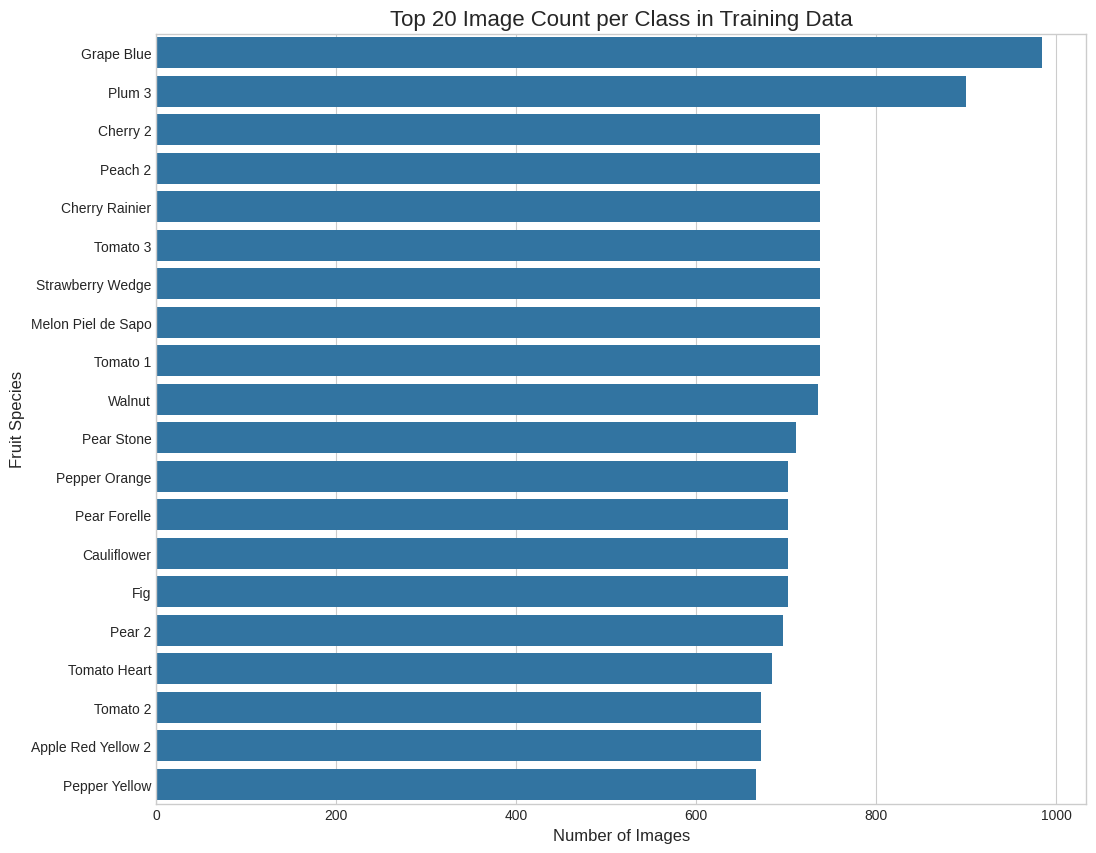

In [5]:
# 학습 데이터의 클래스별 이미지 개수 시각화 (상위 20개만)
plt.figure(figsize=(12, 10))
sns.countplot(y='label', data=train_df, order=train_df['label'].value_counts().iloc[:20].index)
plt.title('Top 20 Image Count per Class in Training Data', fontsize=16)
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Fruit Species', fontsize=12)
plt.show()

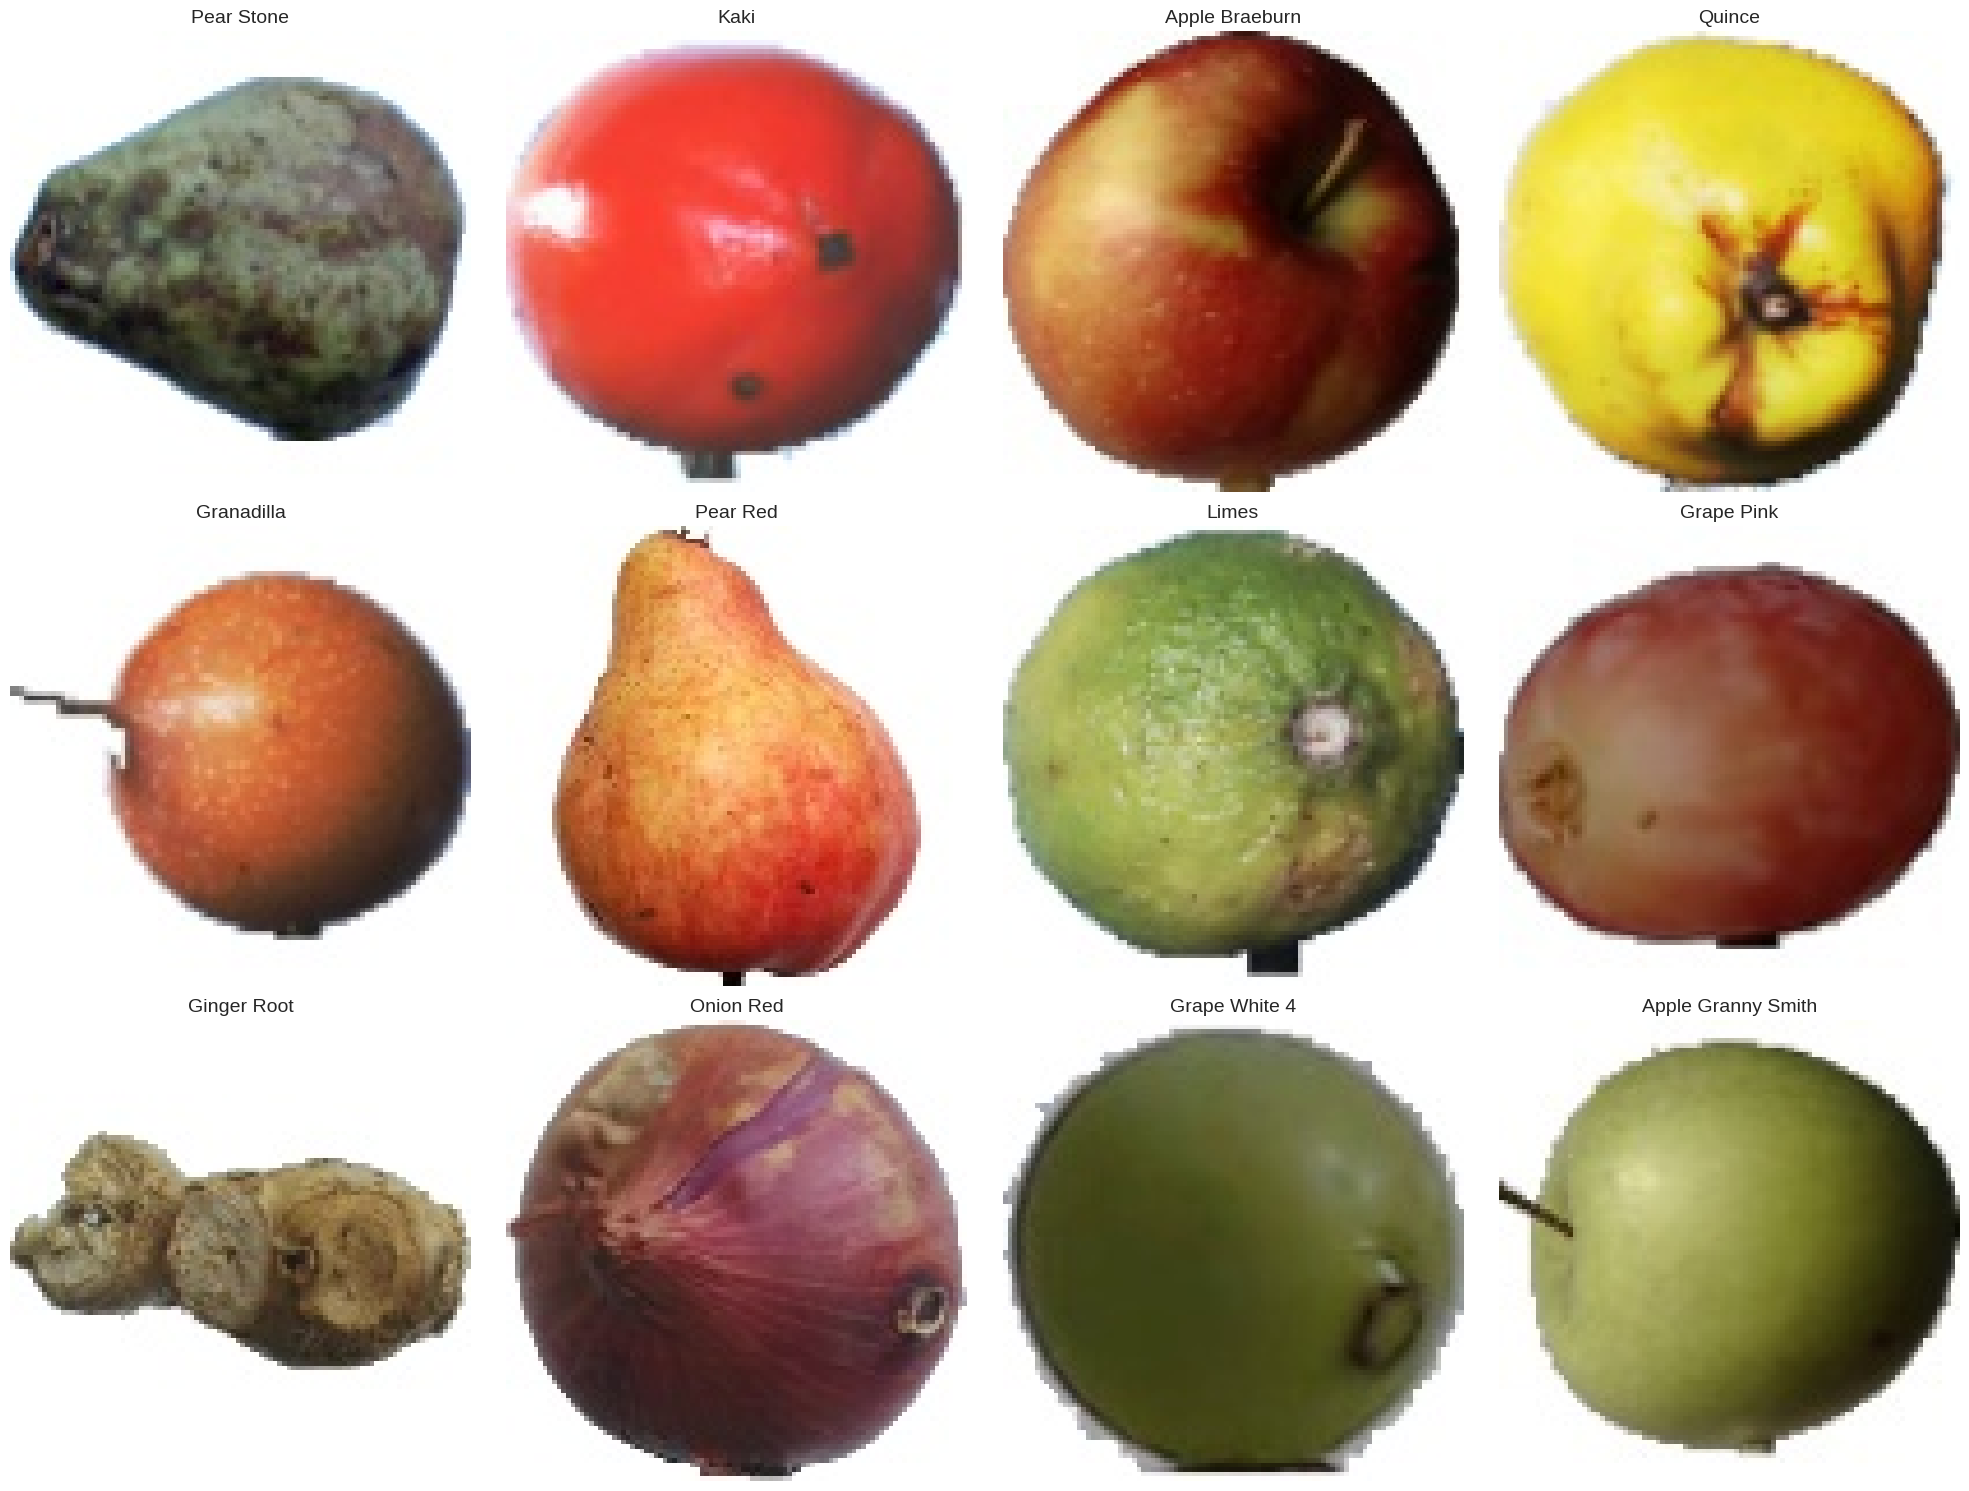

In [6]:
# 샘플 이미지 시각화
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

# 각기 다른 클래스에서 이미지를 샘플링하여 표시
sample_df = train_df.drop_duplicates(subset=['label']).reset_index(drop=True)

for i, row in sample_df.head(12).iterrows():
    img = Image.open(row['filepath'])
    ax = axes[i]
    ax.imshow(img)
    ax.set_title(row['label'], fontsize=14)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# 이미지 변환(Transforms) 정의
# 학습 데이터용 (데이터 증강 포함)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 테스트/검증 데이터용 (데이터 증강 없음)
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset 클래스 정의
class FruitDataset(Dataset):
    def __init__(self, df, class_to_idx, transform=None):
        self.df = df
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['filepath']
        label_name = row['label']
        label_idx = self.class_to_idx[label_name]

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label_idx

# Dataset 및 DataLoader 생성
# 원활한 실습을 위해 데이터의 일부만 사용 (예: 20개 클래스)
selected_classes = classes[:20]
train_sample_df = train_df[train_df['label'].isin(selected_classes)]
test_sample_df = test_df[test_df['label'].isin(selected_classes)]
num_classes = len(selected_classes) # 클래스 개수 재조정

train_dataset = FruitDataset(train_sample_df, class_to_idx, transform=train_transforms)
test_dataset = FruitDataset(test_sample_df, class_to_idx, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"선택된 클래스 개수: {num_classes}")
print(f"조정된 학습 데이터 수: {len(train_dataset)}")
print(f"조정된 테스트 데이터 수: {len(test_dataset)}")

선택된 클래스 개수: 20
조정된 학습 데이터 수: 9694
조정된 테스트 데이터 수: 3241


In [8]:
# EfficientNet-B0 모델 불러오기
model_eff = models.efficientnet_b0(pretrained=True)

# 모델의 마지막 분류기(classifier)를 우리의 문제에 맞게 수정
num_features = model_eff.classifier[1].in_features
model_eff.classifier[1] = nn.Linear(num_features, num_classes)

# 모델을 GPU/CPU로 이동
model_eff = model_eff.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 91.5MB/s]


In [9]:
# ResNet-50 모델 불러오기
model_res = models.resnet50(pretrained=True)

# ResNet의 마지막 분류기(fc)를 수정
num_features = model_res.fc.in_features
model_res.fc = nn.Linear(num_features, num_classes)

# 모델을 GPU/CPU로 이동
model_res = model_res.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 115MB/s]


In [10]:
# 모델 학습을 위한 함수 정의
def train_model(model, train_loader, epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for data, label in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            data = data.to(device)
            label = label.to(device)

            output = model(data)
            loss = criterion(output, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc / len(train_loader)
            epoch_loss += loss / len(train_loader)

        print(f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f}")
    return model

In [11]:
# EfficientNet 모델 학습
print("--- Training EfficientNet ---")
trained_model_eff = train_model(model_eff, train_loader, EPOCHS)

--- Training EfficientNet ---


Epoch 1/5:   0%|          | 0/152 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# ResNet 모델 학습
print("\n--- Training ResNet ---")
trained_model_res = train_model(model_res, train_loader, EPOCHS)

In [ ]:
# 모델 예측을 위한 함수 정의
def predict(model, data_loader):
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for data, label in tqdm(data_loader, desc="Predicting"):
            data = data.to(device)

            output = model(data)
            probs = torch.softmax(output, dim=1) # 확률 계산
            preds = output.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(label.numpy())

    return np.array(all_labels), np.array(all_preds), np.array(all_probs)

# 각 모델의 예측 수행
eff_labels, eff_preds, eff_probs = predict(trained_model_eff, test_loader)
res_labels, res_preds, res_probs = predict(trained_model_res, test_loader)

# Soft Voting 앙상블
# 두 모델의 예측 확률을 평균내어 최종 예측 생성
ensemble_probs = (eff_probs + res_probs) / 2
ensemble_preds = np.argmax(ensemble_probs, axis=1)

# 실제 레이블은 동일
true_labels = eff_labels

In [ ]:
# 각 모델 및 앙상블 모델의 정확도 출력
print("--- Performance Evaluation ---\n")
print(f"EfficientNet Accuracy: {accuracy_score(true_labels, eff_preds):.4f}")
print(f"ResNet Accuracy: {accuracy_score(true_labels, res_preds):.4f}")
print(f"Ensemble (Soft Voting) Accuracy: {accuracy_score(true_labels, ensemble_preds):.4f}")

# 앙상블 모델의 Classification Report
print("\n--- Ensemble Model Classification Report ---\n")
# 클래스 이름 매핑
target_names = [idx_to_class[i] for i in sorted(list(set(true_labels)))]
print(classification_report(true_labels, ensemble_preds, target_names=target_names))

In [ ]:
# 앙상블 모델의 혼동 행렬(Confusion Matrix) 시각화
cm = confusion_matrix(true_labels, ensemble_preds)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Ensemble Model Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()